Continuous waveform mode
========================

In this tutorial we will demonstrate continuous waveform mode (see [Continuous waveform mode](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/documentation/sequencer.html#continuous-waveform-mode)).
In addition, we will observe the output on an oscilloscope to demonstrate the results.

We can perform this tutorial with either a Pulsar or a Cluster QCM/QRM . We use the term 'QxM' encompassing both QCM and QRM modules.

To run this tutorial please make sure you have installed and enabled ipywidgets: 
```
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
```

Setup
-----

First, we are going to import the required packages.

In [1]:
# Import ipython widgets
import json
import math
import os

import ipywidgets as widgets
import matplotlib.pyplot
import numpy

# Set up the environment.
import scipy.signal
from IPython.display import display
from ipywidgets import fixed, interact, interact_manual, interactive

from qblox_instruments import Cluster, PlugAndPlay, Pulsar

### Scan For Devices

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/pnp.html) for more info).

In [2]:
# Scan for available devices and display
with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()
    device_keys = list(device_list.keys())

# create widget for names and ip addresses
connect = widgets.Dropdown(
    options=[(device_list[key]["description"]["name"]) for key in device_list.keys()],
    description="Select Device",
)
print(
    "The following widget displays all the existing modules that are connected to your PC which includes the Pulsar modules as well as a Cluster. Select the device you want to run the notebook on."
)
display(connect)

The following widget displays all the existing modules that are connected to your PC which includes the Pulsar modules as well as a Cluster. Select the device you want to run the notebook on.


Dropdown(description='Select Device', options=('cluster-mm',), value='cluster-mm')

#### Pulsar QxM <a id='pulsar_setup'></a>
Run these cells after selecting the your Pulsar module. Skip to the [Cluster QxM section](#cluster_setup) below if you have selected a Cluster module.

In [ ]:
Pulsar.close_all()

# Retrieve device name and IP address
device_name = connect.value
device_number = connect.options.index(device_name)
ip_address = device_list[device_keys[device_number]]["identity"]["ip"]

# Connect to device and reset
qxm = Pulsar(f"{device_name}", ip_address)
qxm.reset()
print(f"{device_name} connected at {ip_address}")
print(qxm.get_system_state())

Skip to the next section [(Generate Waveform)](#gen_wf) if you are not using a cluster. 

#### Cluster QxM <a id='cluster_setup'></a>
First we connect to the Cluster using its IP address. Go to the [Pulsar QxM section](#pulsar_setup) if you are using a Pulsar.


In [3]:
# close all previous connections to the cluster
Cluster.close_all()

# Retrieve device name and IP address
device_name = connect.value
device_number = connect.options.index(device_name)
ip_address = device_list[device_keys[device_number]]["identity"]["ip"]

# connect to the cluster and reset
cluster = Cluster(device_name, ip_address)
cluster.reset()
print(f"{device_name} connected at {ip_address}")

cluster-mm connected at 192.168.0.2


We then find all available cluster modules to connect to them individually.

In [4]:
# Find all QRM/QCM modules
available_slots = {}
for module in cluster.modules:
    # if module is currently present in stack
    if cluster._get_modules_present(module.slot_idx):
        # check if QxM is RF or baseband
        if module.is_rf_type:
            available_slots[f"module{module.slot_idx}"] = ["QCM-RF", "QRM-RF"][
                module.is_qrm_type
            ]
        else:
            available_slots[f"module{module.slot_idx}"] = ["QCM", "QRM"][
                module.is_qrm_type
            ]

# List of all QxM modules present
connect_qxm = widgets.Dropdown(options=[key for key in available_slots.keys()])

print(available_slots)
# display widget with cluster modules
print()
print("Select the QxM module from the available modules in your Cluster:")
display(connect_qxm)

{'module3': 'QRM', 'module5': 'QCM-RF', 'module8': 'QCM', 'module16': 'QRM-RF'}

Select the QxM module from the available modules in your Cluster:


Dropdown(options=('module3', 'module5', 'module8', 'module16'), value='module3')

Finally, we connect to the selected Cluster module. 

In [6]:
# Connect to the cluster QxM module
module = connect_qxm.value
qxm = getattr(cluster, module)
print(f"{available_slots[connect_qxm.value]} connected")
print(cluster.get_system_state())

QCM connected
Status: OKAY, Flags: NONE, Slot flags: NONE


<a id='gen_wf'>Generate waveforms</a>
------------------

Next, we are going to generate a couple of waveforms that we are going to upload to the instrument in the next step.

In [7]:
# Waveform parameters
waveform_length = 120  # nanoseconds (needs to be a multiple of 4 ns)

# Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
    "gaussian": {
        "data": scipy.signal.gaussian(
            waveform_length, std=0.12 * waveform_length
        ).tolist(),
        "index": 0,
    },
    "sine": {
        "data": [
            math.sin((2 * math.pi / waveform_length) * i)
            for i in range(0, waveform_length)
        ],
        "index": 1,
    },
    "sawtooth": {
        "data": [(1.0 / (waveform_length)) * i for i in range(0, waveform_length)],
        "index": 2,
    },
    "block": {"data": [1.0 for i in range(0, waveform_length)], "index": 3},
}

Let's plot the waveforms to see what we have created.

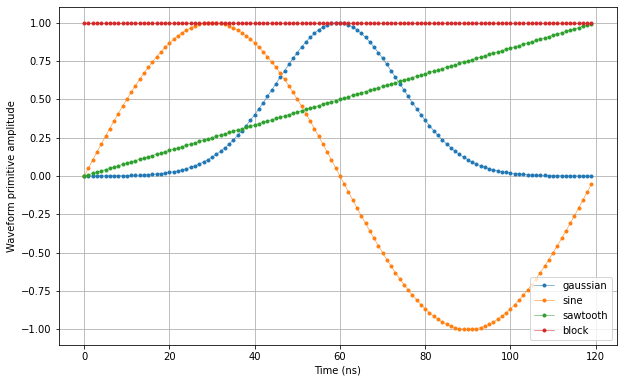

In [8]:
time = numpy.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = matplotlib.pyplot.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time[: len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

matplotlib.pyplot.draw()
matplotlib.pyplot.show()

Upload waveforms
----------------

Now that we know that the waveforms are what we expect them to be, let's upload them to the instrument.
To do this we need to store the waveforms in a JSON file together with a Q1ASM program for the sequence
processor. Since we are going to use continuous waveform mode, the sequence processor will be bypassed 
and the Q1ASM program can be trivial (i.e. `stop`).

In [9]:
# Sequence program.
seq_prog = "stop"

# Check waveform length.
for name in waveforms:
    assert (
        len(waveforms[name]["data"]) % 4
    ) == 0, (
        "In continuous waveform mode the lenght of a waveform must be a multiple of 4!"
    )

# Add sequence program and waveforms to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": {},
    "program": seq_prog,
}
with open("cont_wave_mode.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0 and 1, which will drive outputs $\text{O}^{[1-2]}$ and $\text{O}^{[3-4]}$ respectively.

In [10]:
# Upload sequence.
qxm.sequencer0.sequence("cont_wave_mode.json")
qxm.sequencer1.sequence("cont_wave_mode.json")

Play waveforms
--------------

The waveforms have been uploaded to the instrument. Now we need to configure the instrument to run in continuous waveform mode. We
do this by setting the following parameters of the sequencers.

In [11]:
# Configure the sequencers to run in continuous waveform mode.
for sequencer in [qxm.sequencer0, qxm.sequencer1]:
    sequencer.cont_mode_en_awg_path0(True)
    sequencer.cont_mode_en_awg_path1(True)

# Map sequencers to specific outputs (but first disable all sequencer connections).
for sequencer in qxm.sequencers:
    for out in range(0, 4):
        if hasattr(sequencer, "channel_map_path{}_out{}_en".format(out % 2, out)):
            sequencer.set("channel_map_path{}_out{}_en".format(out % 2, out), False)

# If it is a QRM, we only map sequencer 0 to the outputs.
qxm.sequencer0.channel_map_path0_out0_en(True)
qxm.sequencer0.channel_map_path1_out1_en(True)
if qxm.is_qcm_type:
    qxm.sequencer1.channel_map_path0_out2_en(True)
    qxm.sequencer1.channel_map_path1_out3_en(True)

# Set specific waveform to specific output.
qxm.sequencer0.cont_mode_waveform_idx_awg_path0(0)  # Gaussian on O1
qxm.sequencer0.cont_mode_waveform_idx_awg_path1(1)  # Sine on O2
qxm.sequencer1.cont_mode_waveform_idx_awg_path0(2)  # Sawtooth on 03
qxm.sequencer1.cont_mode_waveform_idx_awg_path1(3)  # DC on O4

Now let's start playback.

In [12]:
# Arm and start both sequencers.
qxm.arm_sequencer(0)
qxm.arm_sequencer(1)
qxm.start_sequencer()

# Print status of both sequencers (should now say Q1 stopped, because of the stop instruction).
print(qxm.get_sequencer_state(0))
print(qxm.get_sequencer_state(1))

Status: STOPPED, Flags: NONE
Status: STOPPED, Flags: NONE


Check waveforms
---------------

The instrument is now running in continuous waveform mode. Now let's connect an oscilloscope and check the outputs.
We connect all output channels of the QXM to two/four channels of an oscilloscope.
On the scope we are able to see that all waveforms are being generated correctly:

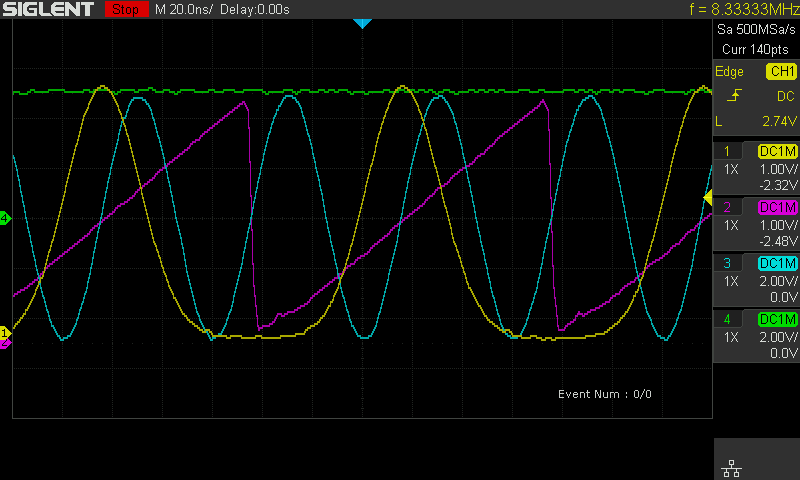

Outputs: Yellow=$\text{O}^{1}$, Blue=$\text{O}^{2}$, Purple=$\text{O}^{3}$ and Green=$\text{O}^{4}$

Stop
----

Finally, let's stop the playback and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before 
closing the connection by uncommenting the corresponding lines. 

In [13]:
# Stop both sequencers.
qxm.stop_sequencer()

# Print status of both sequencers (should now say it is stopped).
print(qxm.get_sequencer_state(0))
print(qxm.get_sequencer_state(1))
print()

# Uncomment the following to print an overview of the instrument parameters.
# Print an overview of the instrument parameters.
# print("Snapshot:")
# qxm.print_readable_snapshot(update=True)

# Close the instrument connection.
Pulsar.close_all()
Cluster.close_all()

Status: STOPPED, Flags: FORCED_STOP
Status: STOPPED, Flags: FORCED_STOP

